# Trasferimento della conoscenza appresa

La capacità delle CNN di estrarre autonomamente le feature di cui necessitano non è una caratteristica "gratuita". Difatti, uno dei principali svantaggi nell'uso delle CNN è che il loro addestramento richiede (tipicamente) una mole di dati nettamente superiore a quella richiesta per addestrare classiche (o shallow) ANNs, su di uno stesso task. In particolare, il numero di campioni labellati necessari ad addestrare una CNN cresce al crescere del numero di neuroni (e quindi all'aumentare della profondità della rete). 

Negli anni, la disponibilità di nuovi sorgenti di dati e maggior potenza computazionale, ha portato quindi allo sviluppo di CNN sempre più profonde e performanti. Tra tutti i dataset, quello che probabilmente ha contribuito maggiormente è [ImageNet](http://image-net.org/update-sep-17-2019), un dataset (e una competizione) di oltre un milione e mezzo di immagini naturali, organizzate in mille classi. 

È proprio grazie ad ImageNet che le CNN hanno iniziato a mostrare le loro potenzialità, al punto che è ormai prassi comune usare ImageNet come benchmark ogni volta che viene pubblicata una nuova architettura basata su CNN. Ad oggi, esistono tantissime CNN in grado di ottenere performance notevoli su ImageNet, quali ad esempio le famose AlexNet, VGG, DenseNet, e cosi via. Sfortunatamente, queste reti presentano spesso un numero molto elevato di neuroni e il loro addestramento su dataset differenti da ImageNet (ed in particolare su dataset con un numero di campioni non paragonabile) è estremamente complesso se non impossibile.

Fortunatamente, esiste una soluzione per utilizzare reti progettate per ImageNet su un task differente. In particolare, si è visto che le features apprese dai layers convoluzionali delle reti addestrate su ImageNet sono molto generiche e ben si prestano ad un'ampia varietà di domini differenti. L'idea è quindi quella di sfruttare ImageNet per pre-addestrare una CNN, prima di effettuare l'addestramento sul vero problema. Questo approccio prende il nome di Knowledge Transfer (ossia trasferimento della conoscenza) e può essere applicato in due modalità principali: 

*   **Fine Tuning**, in cui una rete pre-addestrata è successivamente "raffinata" sui campioni del dataset target
*   Utilizzo della rete pre-addestrata come **feature extractor**, ossia come estrattore di features per le immagini del dataset target, da utilizzarsi poi con un classificatore "classico"

Nell'immagine seguente è riportata una rappresentazione semplificata delle due modalità di uso del knowledge transfer applicata al caso di AlexNet.

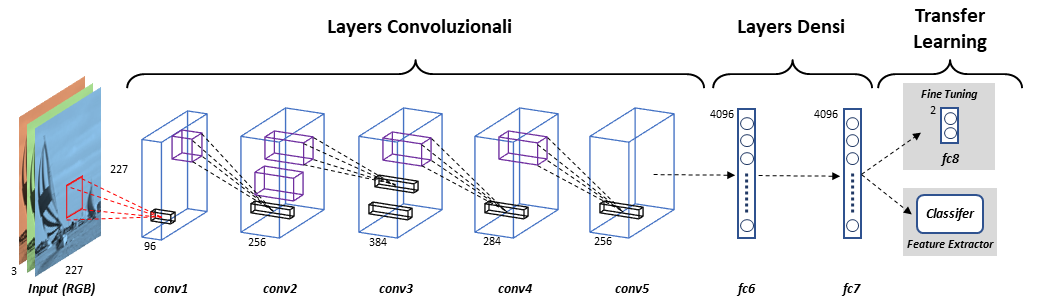

Nelle sezioni seguenti vedremo come effettuare entrambe le modalità in PyTorch. Come CNN pre-addestrata useremo AlexNet, data la sua struttura semplice ed intuitiva. Come dataset target useremo lo UIUC Sports Event Dataset (noto comunemente come [Event8](http://vision.stanford.edu/lijiali/event_dataset/), un dataset di circa 1500 immagini naturali raggruppate in otto differenti eventi sportivi.

## Caricamento di una rete pre-addestrata

Utilizzare una rete pre-addestrata è concettualmente ed operativamente anaologo a quanto fatto nella precedente lezione quando abbiamo salvato e poi caricato una CNN. La differenza principale è che in questo caso non siamo stati noi a salvare lo stato della rete, ma qualcun altro lo ha fatto al posto nostro. 

PyTorch mette a disposizione una vasta gamma di CNN pre-addestrate su ImageNet nel package `torchvision.models`. Ad esempio, per caricare AlexNet (la rete che useremo come esempio in tutta la lezione) pre-addestrata su ImageNet è possibile procedere come segue.

In [ ]:
######################################################
#                                                    #
#  Codice di supporto. DA ESEGUIRE SENZA MODIFICARE  #
#                                                    #
######################################################

!mkdir /home/jovyan/.cache/torch/ /home/jovyan/.cache/torch/hub/ /home/jovyan/.cache/torch/hub/checkpoints/
!cp alexnet-owt-4df8aa71.pth /home/jovyan/.cache/torch/hub/checkpoints/

In [ ]:
import torchvision
from torchvision import datasets, models, transforms

modello = torchvision.models.alexnet(pretrained=True)

## Dataset 

L'uso di reti pre-addestrate si rivela partiolarmente utile nel caso in cui il problema in esame non presenti un numero di campioni sufficienti ad effettuare un addestramento "from scratch" (ossia un addestramento "da zero"), cosi come fatto invece nelle precedenti lezioni. 

In questa lezione useremo il dataset [Event8](http://vision.stanford.edu/lijiali/event_dataset/), caratterizzato da immagini di diversa risoluzione e dimensione, appartenenti a otto differenti eventi sportivi:

*   Canottaggio (250 immagini, indicato come rowing)
*   Badminton (200 immagini)
*   Polo (182 immagini)
*   Bocce (137 immagini)
*   Snowboard (190 immagini)
*   Cricket (236 immagini, indicato come croquet)
*   Vela (190 immagini, indicato come sailing)
*   Arrampicata (194 immagini, indicato come rock climbing)

In questo caso, il dataset non è tra quelli presenti in TorchVision. Per caricarlo, dobbiamo quindi procedere in maniera differente.  

In [ ]:
#####################################################################################
#                                                                                   #
#   L'esecuzione della cella può richiedere diversi minuti.                         #
#                                                                                   #
#####################################################################################

import patoolib
import urllib
import os
import torch
import torchvision
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset

#Parametri 
dimBatchTrain = 64
dimBatchVal = 64
dimBatchTest = 128

#Funzione per lo split del training set
def train_val_dataset(dataset, validation=0.20):
    trainIdx, valIdx = train_test_split(list(range(len(dataset))), test_size=validation)
    trainingSet = Subset(dataset, trainIdx)
    validationSet = Subset(dataset, valIdx)
    return(trainingSet, validationSet)  

#Estrazione
patoolib.extract_archive("event_dataset.zip", outdir=os.getcwd())

#Caricamento delle immagini
trasf = transforms.Compose([transforms.RandomResizedCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
trainingSet = datasets.ImageFolder("event_img", transform=trasf)

#Mapping da classe a indice
indiciClassi = trainingSet.class_to_idx
print(indiciClassi)

#Creazione dei dataloader
trainingSet, testSet = train_val_dataset(trainingSet, validation=0.20)
trainingSet, validationSet = train_val_dataset(trainingSet, validation=0.25)
trainingLoader = torch.utils.data.DataLoader(trainingSet, batch_size=dimBatchTrain, shuffle=True)
validationLoader = DataLoader(validationSet, batch_size = dimBatchVal, shuffle=True)
testLoader = DataLoader(testSet, batch_size = dimBatchTest, shuffle=True)

Tre sono gli aspetti principali da notare nel codice presentato:

1.   Nella trasformazione abbiamo inserito un resize delle immagini a 224x224 pixel. Questa cosa è necessaria in quanto il dataset utilizzato presenta immagini di dimensioni non uniforme, mentre la rete pre-addestrata utilizzata necessita immagini in input di 224x224 pixels
2.   Sempre nella trasformazione usiamo due triple di valori per la normalizzazione. La motivazione è identica a quando, negli eserci precedenti, usavamo 0.5. La differenza in termini di tupla, è che si tratta di due triple in quanto stiamo lavorando con immagini RGB. La differenza in termini di valori è che quelli riportati sono la media e la deviazione standard (per ogni canale) misurati sul training set di ImageNet. Dato che stiamo usando una rete pre-addestrata su quel training set, è di cruciale importanza effettuare la normalizzazione in questo modo
3.   Non essendo presente tra i dataset messi a disposizione da PyTorch, in questo esempio hai dovuto scaricare tu il dataset, estrarlo e poi importarlo usando il metodo `datasets.ImageFolder`. Questo metodo non fa altro che caricare le immagini a partire da una cartella, usando il nome della sottocartella come label per le immagini in essa contenute. Per sapere quale indice è stato poi associato ad ognuna delle classi, è possibiile usare il metodo `class_to_idx`.


## Fine-Tuning

Il termine fine-tuning vuole indicare una modalità di addestramento in cui si "raffinano" le capacità di classificazione di una rete pre-addestrata. In sostanza, l'idea è quella di partire da un set di pesi già addestrati su un particolare dataset (ad esempio ImageNet) e continuare l'addestramento sul dataset target affinché i pesi possano specializzarsi al nuovo problema.

Affinchè ciò possa accadere è necessario che la CNN subisca un nuovo processo di addestramento. Tuttavia, dato che la rete ha già delle capacità pregresse (in quanto pre-addestrata), il tempo di addestramento e il numero di campioni richiesti per convergere sono (tipicamente) molto inferiori a quelli richiesti nel caso di un addestramento da zero (noto come "from scratch").

Dato che non si vuole perdere la conoscenza pre-acquisita (e in particolare non si vuole perdere la capacità della rete di estrarre features efficaci) in genere si ri-addestrano solo gli ultimi livelli (molto spesso solo i fully connected). 

L'esecuzione della fase di addestramento del codice seguente potrebbe richiedere **una quantità di tempo considerevole**. Per questo motivo, è presente una cella alternativa in grado di caricare i parametri e le variabili risultanti da un'esecuzione della cella precedente.

In [ ]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim, Tensor

#Creiamo un metodo che, a partire da Dati e Labels, calcoli Loss e Accuracy (dato che lo useremo per training, test e validation)
def valutaOutputEPerformance(modello, criterion, dati, labels):
  if torch.cuda.is_available():
    dati = dati.cuda()
    labels = labels.cuda()
  
  output = modello(dati) 
  loss = criterion(output, labels) 
  campioniCorretti = (torch.max(output, 1)[1].view(labels.size()).data == labels).sum()
  accuracy = 100.0 * campioniCorretti/dati.size(0)
  return(output, loss, accuracy.item())

#Parametri di addestramento
epoche = 15
lr = 0.001     

#Instanziazione della rete a partire dalla rete pre-addestrata
modelloFineTuned = copy.deepcopy(modello)                  

#Sostituzione dell'ultimo livello
modelloFineTuned.classifier[6] = nn.Linear(4096, len(indiciClassi))

#Congelamento dei layer che non vogliamo ri-addestrare (i convoluzionali)
for param in modelloFineTuned.parameters():
  param.requires_grad = False

#Abilitazione della backpropagation sui layer fully connected
for param in modelloFineTuned.classifier.parameters():
  param.requires_grad = True

#Definizione di loss e algoritmo di ottimizzazione
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelloFineTuned.parameters(), lr=lr)

#Gestione della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
modelloFineTuned.to(device)

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VUOLE EFFETTUARE L'ADDESTRAMENTO.  #
#               Eseguire la cella seguente se si vogliono caricare le variabili     #
#               necessarie già pronte per l'uso. L'esecuzione della cella può       #
#               richiedere diversi minuti.                                          #
#                                                                                   #
##################################################################################### 

#Ciclo di addestramento
lossTraining = []
accuracyTraining = []
lossValidation = []
accuracyValidation = []

for e in range(1, epoche + 1):
  lossTrainEpoca = 0
  lossValEpoca = 0
  for datiBatchTrain, labelsBatchTrain in trainingLoader:
      outputTrain, lossTrain, accuracyTrain = valutaOutputEPerformance(modelloFineTuned, criterion, datiBatchTrain, labelsBatchTrain)      
      optimizer.zero_grad()
      lossTrain.backward()
      optimizer.step()
      lossTrainEpoca += lossTrain.item()*datiBatchTrain.size(0)    
  lossTraining.append(lossTrainEpoca/len(trainingLoader))
  accuracyTraining.append(accuracyTrain)

  #Calcolo delle performance sul validation set, ad ogni fine epoca
  for datiBatchVal, labelsBatchVal in validationLoader:
      outputVal, lossVal, accuracyVal = valutaOutputEPerformance(modelloFineTuned, criterion, datiBatchVal, labelsBatchVal)      
      lossValEpoca += lossVal.item()*datiBatchVal.size(0)    
  lossValidation.append(lossValEpoca/len(validationLoader))
  accuracyValidation.append(accuracyVal)
  
  print("Epoca {}:".format(e))
  print("Loss sul Training Set: {} - Accuracy sul Training Set: {}".format(lossTraining[-1:], np.mean(accuracyTraining)))
  print("Loss sul Validation Set: {} - Accuracy sul Validation Set: {}".format(lossValidation[-1:], np.mean(accuracyValidation)))
  print("--------------------------------------------------------------------------------------------------")

In [ ]:
#####################################################################################
#                                                                                   #
#   ATTENZIONE: eseguire questa cella SOLO SE SI VOGLIONO CARICARE I DATI PRONTI.   #
#               Non è necessario eseguire questa cella se si è eseguita quella      #
#               precedente, dove è stato effettuato l'addestramento.                #
#                                                                                   #
##################################################################################### 

import pickle

with open('preElaborati.pkl', 'rb') as f:
    lossTraining, lossValidation, accuracyTraining, accuracyValidation = pickle.load(f)
modello.load_state_dict(torch.load('preElaborato.pth'))

print('Dati pre-elaborati caricati con successo!')

In [ ]:
#####################################################################################
#                                                                                   #
#   L'esecuzione della cella può richiedere diversi secondi.                        #
#                                                                                   #
#####################################################################################

#Visualizzazione delle training curves
plt.figure()

plt.subplot(1, 2, 1) 
plt.plot(np.arange(0, epoche, 1), lossTraining, label="Training Loss", color="black")
plt.plot(np.arange(0, epoche, 1), lossValidation, label="Validation Loss", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Loss")
plt.tight_layout()
plt.legend(loc="best")

plt.subplot(1, 2, 2) 
plt.plot(np.arange(0, epoche, 1), accuracyTraining, label="Training Accuracy", color="black")
plt.plot(np.arange(0, epoche, 1), accuracyValidation, label="Validation Accuracy", color="dimgrey")
plt.xlabel("Epoche")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc="best")

#Calcolo delle performance finali sul test set
accuracyTest = []
campioniTotaliTest = 0
for datiBatchTest, labelsBatchTest in testLoader:
  outputTest, lossTest, accuracyT = valutaOutputEPerformance(modelloFineTuned, criterion, datiBatchTest, labelsBatchTest)       
  accuracyTest.append(accuracyT)
  campioniTotaliTest += datiBatchTest.size(0);
print("Numero di campioni nel test set =", campioniTotaliTest)
print("\nAccuracy sul test set =", np.mean(accuracyTest))

Come si vede dal codice, i passaggi sono estremamente simili a quelli effettuati nel classico addestramento from scratch. La principale differenza sta nel fatto che abbiamo esplicitamente "congelato" alcuni layers affinchè la backpropagation non avesse effetto sul valore dei loro pesi. 

Abbiamo invece dovuto effettuare un'operazione più drastica sull'ultimo layer, eliminandolo e sostituendolo con uno nuovo. Difatti, l'ultimo layer è quello dal quale poi sarà determinata la classe predetta e dunque, per questo motivo, presenta tanti neuroni quante sono le possibili classi. Dato che il dataset di pre-training e quello target presentano un differente set di classi (sono due domini differenti), bisogna sostituire il layer finale affinchè la rete possa effettuare una predizione nel nuovo dominio.

Si noti infine che l'uso del metodo `copy.deepcopy(modello)` è a soli fini didattici, in quanto si vuole conservare il modello pre-addestrato originale per la seconda parte di questa lezione.

In [ ]:
#TASK: effettuare la fase di ottimizzazione dei parametri (eventualmente anche utilizzando una differente rete pre-addestrata)
#fino a giungere a buone performance sul nuovo dominio


## Feature Extractor

Utilizzare una CNN pre-addestrata come estrattore di features significa voler sfruttare i kernel addestrati per estrarre un set di features dalle immagini del problema target, da utilizzarsi come imput per un classificatore esterno (non necessariamente una rete neurale). 

Da un punto di vista operativo, estrarre le features con una CNN pre-addestrata consiste nel dare in pasto le immagini del dataset target alla rete e considerare l'output di alcuni livelli intermedi come se fosse un array di features. In genere, si usa l'output di uno degli ultimi livelli fully-connected, in modo da sfruttare la capacità della rete di generare un singolo vettore di valori a partire da un'immagine, già linearizzato e pronto per essere utilizzato da un altro classificatore.

Con questa modalità la CNN pre-addestrata è utilizzata cosi com'è, senza effettuare alcun tipo di nuovo addestramento. Sarà invece addestrato (da zero) il classificatore che si sceglie di usare. 

L'esecuzione del codice seguente potrebbe richiedere una quantità di tempo considerevole. 

In [ ]:
#####################################################################################
#                                                                                   #
#   L'esecuzione della cella può richiedere diversi minuti.                         #
#                                                                                   #
#####################################################################################

import pandas as pd
import numpy as np

#Variabili di appoggio per le immagini e per le features estratte
listaImmagini = []
featuresEstratte = []
listaClasse = []

#Istanziazione della CNN pre-addestrata da usarsi come feature extractor
modelloExtractor = copy.deepcopy(modello)

#Sostituzione dei livelli fully connected, copiando tutti i livelli dalla rete
#tranne l'ultimo layer fully connected (implica che usiamo il penultimo come estrattore di features)
listaLivelli = nn.Sequential(*list(modelloExtractor.classifier.children())[:-1])
modelloExtractor.classifier = listaLivelli

#Gestione della GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
modelloExtractor.to(device)

#Ciclo di estrazione delle features
with torch.no_grad():
    for i in range(0, len(trainingSet)):
      img = trainingSet[i][0].to(device)
      img = img.unsqueeze_(0)
      features = modelloExtractor(img)

      featuresEstratte.append((np.squeeze(features.cpu().detach().numpy())))
      listaClasse.append(trainingSet[i][1])
      listaImmagini.append(i)

#Assemblamento del dataset
datasetEstrattoTraining = pd.DataFrame(featuresEstratte)
colonne = [('feature_' + str(i)) for i in list(range(0, 4096 ))]   #Dato che il livello scelto ha 4096 neuroni
datasetEstrattoTraining.columns =  colonne
datasetEstrattoTraining['Idxs'] = listaImmagini
datasetEstrattoTraining['Classe'] = listaClasse

In [ ]:
#Visualizzazione
datasetEstrattoTraining.head()

In [ ]:
#Salvataggio
datasetEstrattoTraining.to_csv('datasetEstrattoTraining.csv', index=False)

In questo caso non abbiamo avuto la necessità di ri-addestrare la rete. Tuttavia, per questioni di praticità, abbiamo rimosso l'ultimo layer (e quindi usiamo l'output del penultimo layer come features). Si noti che questa operazione non è strettamente necessaria (avremmo potuto infatti usare un hook, cosi come fatto per la visualizzazione delle features apprese da una CNN).

Come detto precedentemente, usare una rete pre-addestrata implica la necessità di effettuare lo stesso preprocessing utilizzato in fase di addestramento. Dunque, anche in questo caso, per ogni immagine di cui vogliamo estrarre le features dobbiamo effettuare tutte le trasformazioni necessarie a renderla adatta all'uso con la rete pre-addestrata scelta.

Si noti infine che nell'esempio abbiamo estratto le features per il solo training set.

In [ ]:
#TASK: estrarre le features anche per il validation e per il test set


In [ ]:
#TASK: effettuare la classificazione con una semplice ANN (si usi lo stesso approccio seguito per l'esercizio 
#finale della lezione 1 della seconda week)
